In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0'

dataset0 = datasets.ImageFolder(root=data_dir)

In [4]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1'

dataset1 = datasets.ImageFolder(root=data_dir)

In [5]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2'

dataset2 = datasets.ImageFolder(root=data_dir)

In [6]:
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset0, dataset1, dataset2])

len(dataset)

10661

In [7]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=450x450>, 0)

In [8]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [9]:
image_tensor, label = dataset[0]

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((450, 450)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomVerticalFlip(p=0.5)
])

test_transform = transforms.Compose([
    transforms.Resize((450, 450)),
    transforms.ToTensor(),
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = dataset[label]
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [11]:
len(train_data), len(val_data)

(8529, 2132)

In [12]:
dataset = TransformDataset(dataset, transform=train_transform)

In [13]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

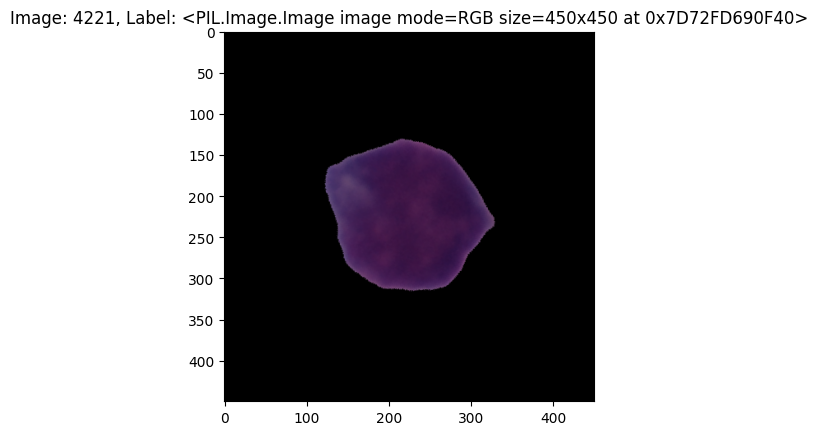

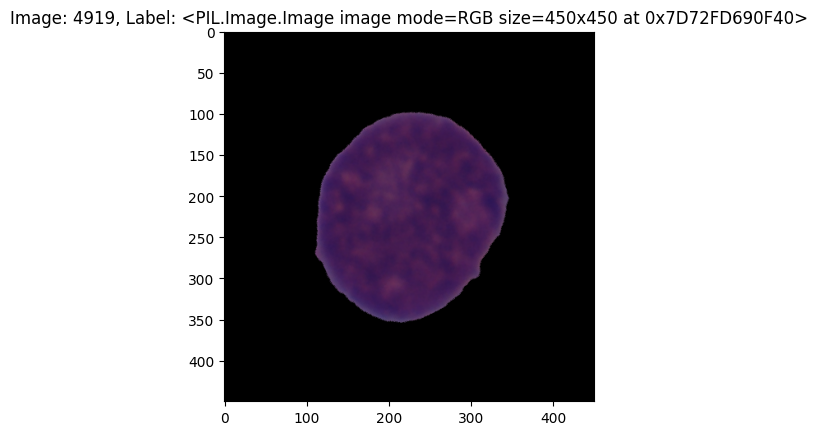

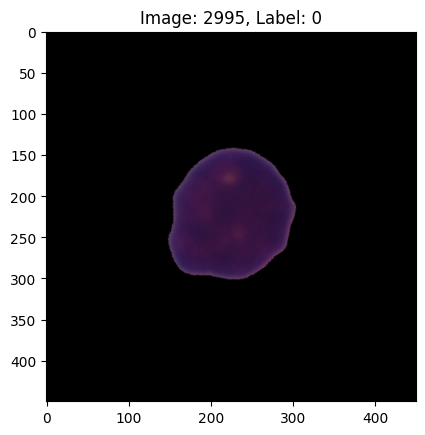

In [14]:
import matplotlib.pyplot as plt
import random

for _ in range(3):
    rand = random.randint(0, 10660) 
    img, label = dataset[rand]

    img = img.numpy()

    img = img.transpose((1, 2, 0))

    label_name = dataset.classes[label]

    plt.imshow(img)
    plt.title(f"Image: {rand+1}, Label: {label_name}")
    plt.show()

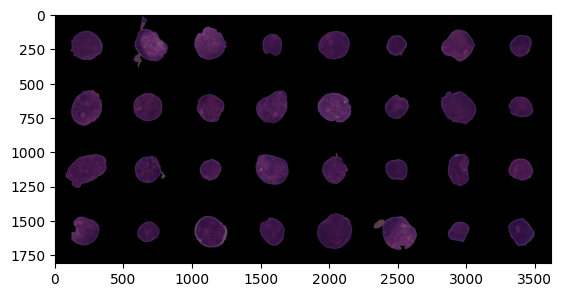

In [15]:
from torchvision.utils import make_grid

loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)
  
batch, labels = next(iter(loader))

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)